<a href="https://colab.research.google.com/github/jade0520/DeepLearning_FromScratch/blob/master/2nd/2_CH06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 580, done.
remote: Total 580 (delta 0), reused 0 (delta 0), pack-reused 580
Receiving objects: 100% (580/580), 29.81 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (349/349), done.


In [ ]:
import os
os.chdir('/content/deep-learning-from-scratch-2')

# 6.1 RNN의 문제점

  * 장기 의존 관계 파악이 어렵다.(기울기 소실/폭발로 인해)

## 6.1.3 기울기 소실과 기울기 폭발의 원인

* 역전파 시 지나는 노드
  1. MatMul: 행렬의 특이 값에 따라 기울기 폭발/소실 
  2. tanh : 0과 1사이의 수가 반복해서 곱해짐, 기울기 소실 >> ReLu사용시 개선




## 6.1.4 기울기 폭발 대책
  * 기울기 클리핑 : 문턱 값을 초과하면 기울기를 제한한다.
    
      기울기 벡터 gradient vector의 방향은 유지/ 크기만 작게 조정

      
 확률적 경사하강법(SGD)가 아닌, 아담Adam과 같은 동적인 학습률을 갖는 옵티마이저optimizer를 사용할 경우, 그래디언트 클리핑을 적용하지 않아도 괜찮으며, 안전장치로 사용 가능.

 [참고 글](https://kh-kim.gitbook.io/natural-language-processing-with-pytorch/00-cover-6/05-gradient-clipping)

In [ ]:
import numpy as np

# 임의 가중치 설정
dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10

grads  = [dW1,dW2]

# max_norm : 문턱 값
def clip_grads(grads, max_norm):
  total_norm = 0

# 기울기 노름 구하기
  for grad in grads : 
    total_norm += np.sum(grad ** 2)   
  total_norm = np.sqrt(total_norm)

  rate = max_norm /(total_norm + 1e-6)

#문턱 값을 초과 할 경우
  if rate < 1 :

    #문턱값에 노름은 나누 값을 기울기에 곱하여 사용한다.
    for grad in grads:
      grad *= rate



# 6.2 기울기 소실과 LSTM

##6.2.1 LSTM의 인터페이스 

  게이트가 추가된 RNN 1) LSTM 2) GRU

  LSTM의 기억셀
  * LSTM 계층에서만 주고 받는다. 

## 6.2.2 LSMT 계층 조립하기
  현재 시간 t의 은닉상태 ht는 현재 기억셀 Ct를 tanh를 거치게 한 값이다. 
  
  이때, 기억셀은 이전 기억셀 Ct-1과 이전 은닉층의 결과, 현재 입력의 조합으로 이루어진다.

  

## 6.2.3 output 게이트

* 은닉상태 ht를 조절하는 게이트. 
* 아다마르 곱을 통하여 ht와 곱해진다.
* 현재 입력과 이전 상태의 출력으로 부터 구하며, 시그 모이드를 거친다.




## 6.2.4 forget 게이트 
  * 이전 기억셀 Ct 에서 무엇을 잊을 지를 결정한다.
  * 이전 기억셀 Ct와 아다마르 곱을 하여 조정하게 된다.
  * 현재 입력과 이전 상태의 출력으로 부터 구하며, 시그 모이드를 거친다.

## 6.2.5 새로운 기억셀
  현재 입력과 이전 은닉층 출력으로 이루어진 새로운 정보 이다. 

  이전시각의 정보중 필요 없는 정보는 잊은 후에 새로운 정보를 받을 수 있게 한는 것이다.

## 6.2.6 input 게이트
 새로 입력 되는 현대 기억중이 얼마나 중요한지를 학습하여, 새로운 정보를 조절하는 게이트이다.
  * 새로운 기억셀 g와 아다마르 곱을 하여 조정하게 된다.
  * 현재 입력과 이전 상태의 출력으로 부터 구하며, 시그 모이드를 거친다.

## 6.2.7 LSTM의 기울기 흐름
  기울기 소실을 없애는 원리

  * 기억셀의 역전파에 있는 두가지 노드
    
    1.  '+' 노드 : 그대로 흘릴 뿐, 기울기 변화 없다.
    2.  '*' 노드 : 행렬곱이 아닌 원소별 곱이며, 매 시각마다 다른 게이트 값과 곱해지므로 곱셈 효과가 누적되지 않는다.


# 6.3 LSTM 구현

LSTM 구현

In [ ]:
class LSTM:
  
  def __init__(self, Wx, Wh, b):
      # 각각의 가중치/편향에는 4개의 가중치/편향(f,g,i,o) 가 저장됨
      self.params = [Wx,Wh, b]
      self.grads = [np.zero_like(Wx), np.zeros_like(Wh), np.zero_like(b)]
      self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    A = np.matmul(x,Wx) + np.matmul(h_prev,Wh) + b

    # 각 용도에 맞게 slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:4*H]

    # gate는 sigmoid / 일반정보는 tanh
    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    c_next = f * c_prev + g * i 
    h_next = o * np.tanh(c_next)


    # 캐시에 일시 저장
    self.cache = (x,h_prev , c_prev, i , f, g, o, c_next)

    return h_next, c_next



## 6.3.1 Time LSTM 구현


순전파 구현을 위해 중간에 h와 c를 전달해줘야함

In [ ]:
class TimeLSTM:
  def __init__(self,Wx, Wh, b, stateful = False):
      self.params = [Wx,Wh,b]
      self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zero_like(b)]
      self.layers = None

      self.h, self.c = None, None
      self.dh = None
      self.stateful = stateful

  def forward(self,xs):
      Wx, Wh, b = self.params   # 초기화한 매개변수 값 저장
      N,T,D = xs.shape          # 미니배치, 시계열 길이, 데이터 개수 저장
      H = Wh.shape[0]           # Wh개수 저장 (은닉층 뉴런 개수 )

      self.layers = []          # 레이어 저장용
      hs = np.empty((N,T,H),dtype = 'f')  # 은닉층 출력

      # 처음 시작할때는 초기 h와 c를 zero로 지정한다.
      if not self.stateful or self.h is None:
          self.h = np.zeros((N,H),dtype = 'f')

      if not self.stateful or self.c is None:
          self.c = np.zeros((N,H),dtype = 'f')

      # 시계열 길이 T만큼 lstm 레이어 생성후 h,c 받고 hs 열에 저장.
      
      for t in range(T):
        layer = LSTM(*self.params)
        self.h, self.c = layer.forward(xs[:,t,:], self.h ,self.c) # 이전 h와 c가 넘겨진다.
        hs[:,t,:] =self.h       # 이때 c는 LSTM 계층 내에서만 도니까 TimeLSTM에서 저장하지는 않는다.

        self.layers.append(layer)
      
      return hs

  def backward(self,dhs) : 
    Wx, Wh, b = self.params
    N,T,H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N,T,D), dtype = 'f')
    dh, dc = 0,0

    # Truncated 이므로 Time LSTM의 처음 시작은 항상 0
    grads = [0, 0, 0]

    # 반대의 순서로 역전파를 진행한다.
    for t in reverse(range(T)):
        layer = self.layers[t]
        dx,dh,dc = layer.backward(dhs[:,t,:]+dh, dc)
        dxs[:,t,:] = dx

        # 같은 가중치를 사용하므로, 기울기는 각각 더해준다.
        for i, grad in enumerate(layer.grads):
            grads[i] += grad
    
    # Time LSTM에 결과 기울기 전하기,// 결과 dxs
    for i, grad in enumerate(grads):
        self.grads[i][...] = grad
        self.dh = dh
        return dxs

  # 포워드에서는 미리 h,c 0으로 셋팅하지 않나? 얘는 왜 필요? >> 다음 TimeLSTM 을 위해 필요한듯??? >>> 한번 밖에 안쓴느거 같은데??????????
  def set_state(self,h, c= None):
      self.h, self.c = h,c 
  
  def reset_state(self):
      self.h, self.c = None

## 6.4 LSTM을 사용한 언어 모델

Done
Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.71
| 에폭 1 |  반복 21 / 1327 | 시간 7[s] | 퍼플렉서티 3853.17
| 에폭 1 |  반복 41 / 1327 | 시간 13[s] | 퍼플렉서티 1241.23
| 에폭 1 |  반복 61 / 1327 | 시간 20[s] | 퍼플렉서티 988.39
| 에폭 1 |  반복 81 / 1327 | 시간 27[s] | 퍼플렉서티 802.29
| 에폭 1 |  반복 101 / 1327 | 시간 33[s] | 퍼플렉서티 693.06
| 에폭 1 |  반복 121 / 1327 | 시간 40[s] | 퍼플렉서티 641.83
| 에폭 1 |  반복 141 / 1327 | 시간 47[s] | 퍼플렉서티 603.28
| 에폭 1 |  반복 161 / 1327 | 시간 53[s] | 퍼플렉서티 583.09
| 에폭 1 |  반복 181 / 1327 | 시간 60[s] | 퍼플렉서티 593.29
| 에폭 1 |  반복 201 / 1327 | 시간 67[s] | 퍼플렉서티 496.74
| 에폭 1 |  반복 221 / 1327 | 시간 73[s] | 퍼플렉서티 499.73
| 에폭 1 |  반복 241 / 1327 | 시간 80[s] | 퍼플렉서티 449.71
| 에폭 1 |  반복 261 / 1327 | 시간 87[s] | 퍼플렉서티 467.33
| 에폭 1 |  반복 281 / 1327 | 시간 93[s] | 퍼플렉서티 452.66
| 에폭 1 |  반복 301 / 1327 | 시간 100[s] | 퍼플렉서티 401.64
| 에폭 1 |  반복 321 / 1327 | 시간 107[s] | 퍼플렉서티 343.59
| 에폭 1 |  반복 341 / 1327 | 시간 113[s] | 퍼플렉서티 405.66
| 에폭 1 |  반복 361 / 1327 | 시간 120[s] | 퍼플렉서티 402.42
| 에폭 1 |  반복 381 / 1327 | 시간 127[s] | 퍼플렉

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

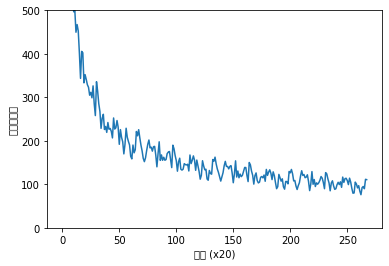

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.95750192010092


In [ ]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습  : max_grad = 기울기 클리핑 문턱
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()